# Principal component analysis

## Import libraries

In [1]:
import os
import os.path as op
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn.plotting import plot_stat_map, show
from nilearn.image import mean_img
from sklearn.decomposition import PCA
from scipy import signal
import seaborn as sns

## Load and prepare data

In [2]:
TR = 0.72
fmri_img_path = "dataset/derivatives/preprocessed_data/subject101410/fMRI/tfMRI_MOTOR_moco_smoothed_4mm.nii.gz"

fmri_img_nii = nib.load(fmri_img_path)

affine = fmri_img_nii.affine

fmri_img = fmri_img_nii.get_fdata()
mean_img_ = mean_img(fmri_img_nii)
del fmri_img_nii

print(f"File loaded! Data shape: {fmri_img.shape}")

File loaded! Data shape: (91, 109, 91, 568)


We get the volume dimensions and number of timepoints with vol_shape and n_vols

In [3]:
vol_shape = fmri_img.shape[:-1]
n_vols = fmri_img.shape[-1]
print(f"Volume shape: {vol_shape}")
print(f"Number of volumes: {n_vols}")

Volume shape: (91, 109, 91)
Number of volumes: 568


We remove the useless voxels (background), then flatten the volume into a vector

In [4]:
# Let's select the non-background voxels
slice_non_background = fmri_img[:,:,:,0] != 0
samples = fmri_img[slice_non_background]
del slice_non_background
print(f"Number of non-background voxels: {samples.shape[0]}")

Number of non-background voxels: 375916


Now, we remove the spatial mean

In [5]:
# 
spatial_means = np.mean(samples, axis=1)
row_means = np.outer(spatial_means, np.ones(n_vols))
X = samples - row_means
print(f"Data matrix shape: {X.shape}")
del samples
del row_means

Data matrix shape: (375916, 568)


## 1. PCA on one volume as one sample

In [6]:
nb_components = 10
pca = PCA(n_components=nb_components)
pca.fit(X.T) 

PCA(n_components=10)

## 2. Selection of components of our choice

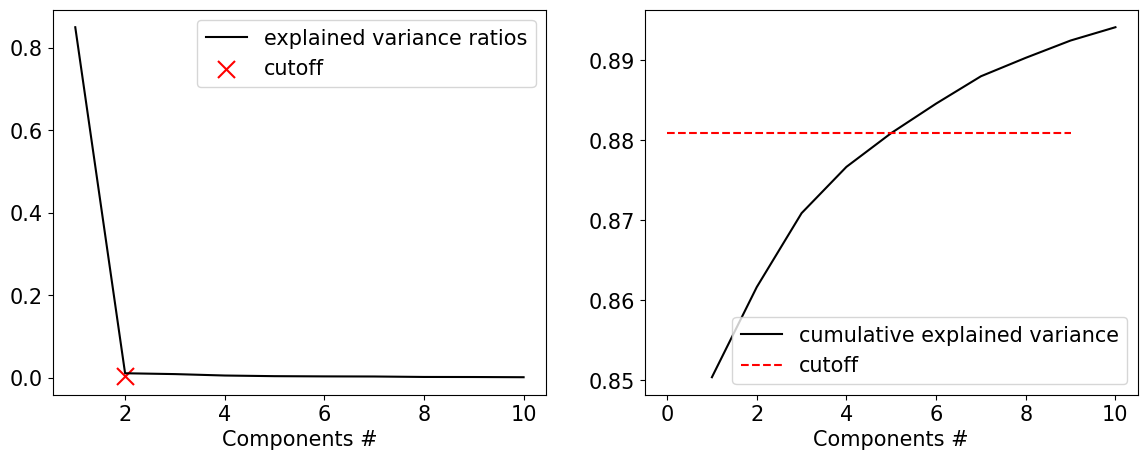

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

ratios = pca.explained_variance_ratio_
cumulative_ratios = np.cumsum(pca.explained_variance_ratio_)
nb_clusters_sel = 2
nb_clusters = 5 #purposefully set to 5 for similarity matrix

ax[0].plot(np.arange(1, len(ratios)+1), ratios, label='explained variance ratios', c='k')
ax[0].scatter([nb_clusters_sel], [ratios[nb_clusters-1]], [150], marker='x', color='r', label='cutoff')
ax[1].plot(np.arange(1, len(cumulative_ratios)+1), cumulative_ratios, label='cumulative explained variance', c='k')
ax[1].hlines(y=cumulative_ratios[nb_clusters-1], xmin=0, xmax=len(ratios)-1, linestyle='--', color='r', label='cutoff')

for k in range(2):
    ax[k].set_xlabel('Components #', size=15)
    ax[k].legend(prop={'size':15})
    ax[k].tick_params(axis='both', which='major', labelsize=15)

os.makedirs('figures', exist_ok=True)
fig.savefig("figures/variance_plot.png", bbox_inches='tight', dpi=150)

We recover the spatial domain

In [16]:
pca_clusters = [] 
slice_non_background = fmri_img[:,:,:,0] != 0
for cluster_idx in range(nb_clusters):
    pca_component = np.zeros(vol_shape)
    pca_component[slice_non_background] = pca.components_[cluster_idx]
    pca_clusters.append(pca_component)
    del pca_component

## Here we are only visualizing the first component, change it by selecting the right visual_idx

Visualize the results

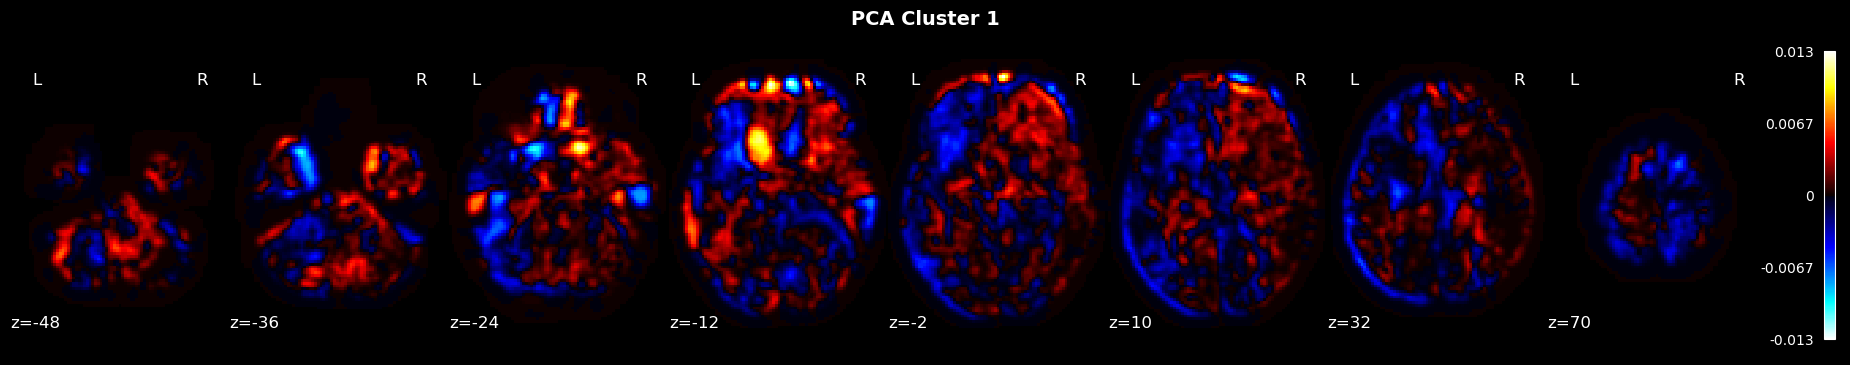

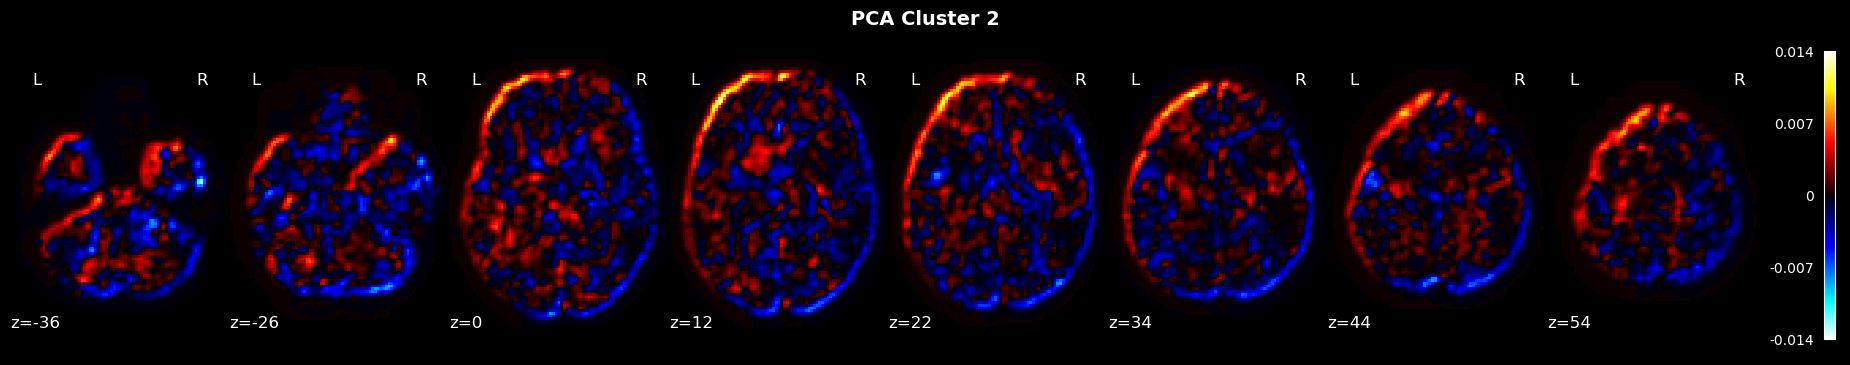

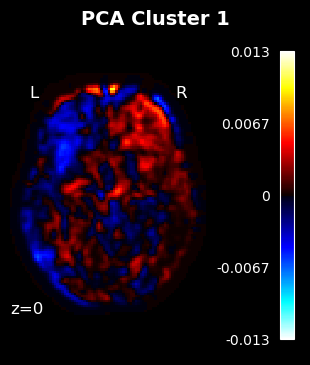

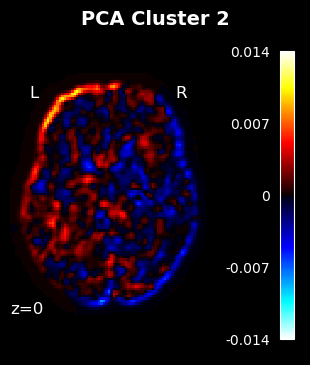

In [39]:
for visual_idx in range(nb_clusters_sel):
    display = plot_stat_map(
        nib.Nifti1Image(pca_clusters[visual_idx], affine),
        bg_img=mean_img_,
        threshold=0,                     # slight threshold to reduce noise
        display_mode='z',
        cut_coords=8,                      # show multiple slices
        black_bg=True,                    # light background usually looks cleaner
        colorbar=True
    )
    
    plt.text(
        0.5, 1.02, f'PCA Cluster {visual_idx + 1}',  # increased y from 0.95 → 1.02
        transform=plt.gcf().transFigure,
        color='white',
        fontsize=14,
        ha='center', va='bottom', weight='bold'
    )

    # Ensure figure background is black
    fig = plt.gcf()
    fig.patch.set_facecolor('black')
    ax = plt.gca()
    ax.set_facecolor('black')
    #plt.savefig(f'figures/PCA{visual_idx+1}.png', bbox_inches='tight', dpi=200)
    plt.show()

for visual_idx in range(nb_clusters_sel):
    display = plot_stat_map(
        nib.Nifti1Image(pca_clusters[visual_idx], affine),
        bg_img=mean_img_,
        threshold=0,                     # slight threshold to reduce noise
        display_mode='z',
        cut_coords=[0],                      # show multiple slices
        black_bg=True,                    # light background usually looks cleaner
        colorbar=True
    )

    plt.text(
        0.5, 1.02, f'PCA Cluster {visual_idx + 1}',  # increased y from 0.95 → 1.02
        transform=plt.gcf().transFigure,
        color='white',
        fontsize=14,
        ha='center', va='bottom', weight='bold'
    )

    # Ensure figure background is black
    fig = plt.gcf()
    fig.patch.set_facecolor('black')
    ax = plt.gca()
    ax.set_facecolor('black')
    #plt.savefig(f'figures/PCA{visual_idx+1}_single_slice.png', bbox_inches='tight', dpi=200)
    plt.show()

## 3. Compute pairwise similarity

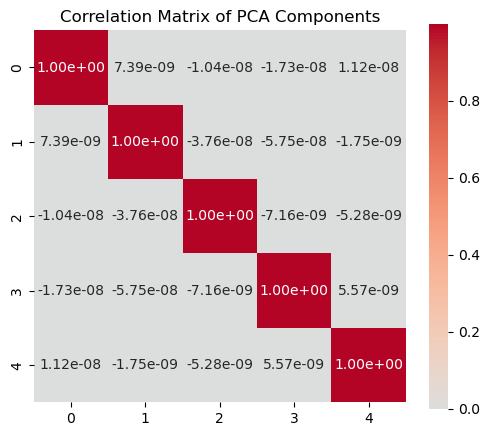

In [11]:
pca_clusters_subset = pca_clusters[:5]
pca_clusters_flat = np.array(pca_clusters_subset, dtype='float32').reshape(len(pca_clusters_subset), -1)

R_ = np.dot(pca_clusters_flat, pca_clusters_flat.T)

plt.figure(figsize=(6, 5))
sns.heatmap(R_, annot=True, fmt='.2e', cmap='coolwarm', center=0, square=True)
plt.title("Correlation Matrix of PCA Components")
plt.show()

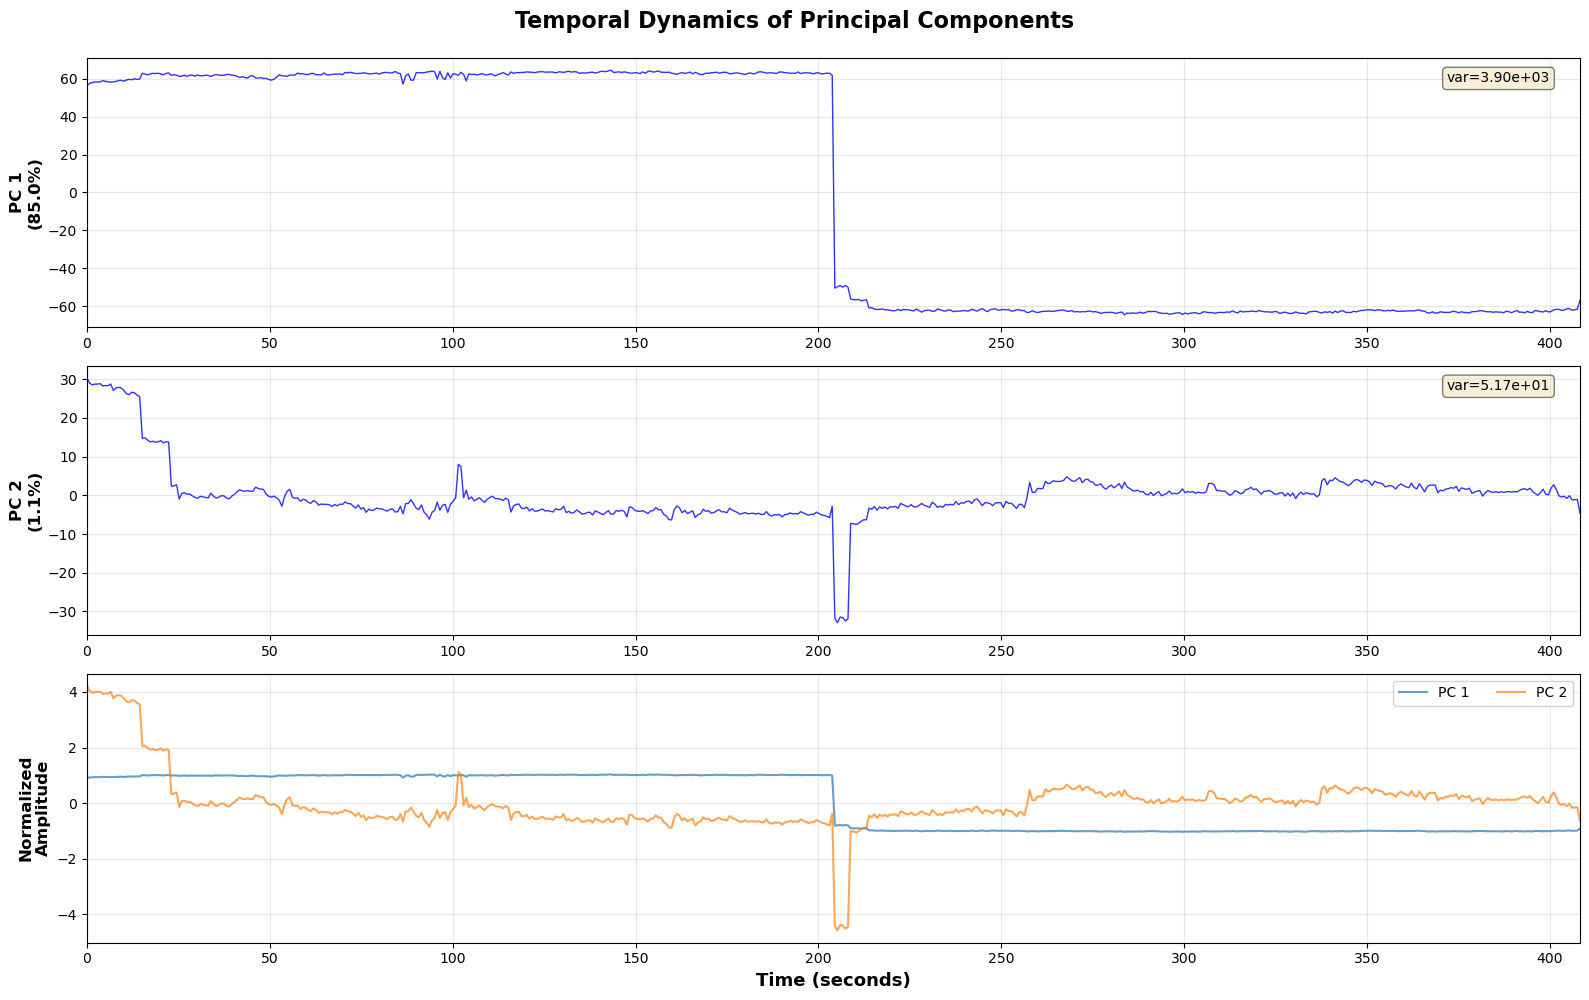

In [40]:
# Project data onto principal components to get time courses
time_courses = pca.transform(X.T)

fig, axes = plt.subplots(nb_clusters_sel + 1, 1, figsize=(16, 10))
time_vec = np.arange(n_vols) * TR

# Plot individual component time courses
for idx in range(nb_clusters_sel):
    axes[idx].plot(time_vec, time_courses[:, idx], 'b-', linewidth=1, alpha=0.8)
    axes[idx].set_ylabel(f'PC {idx + 1}\n({ratios[idx]:.1%})', size=12, fontweight='bold')
    axes[idx].grid(alpha=0.3)
    axes[idx].set_xlim([0, time_vec[-1]])
    
    # Add variance annotation
    variance = np.var(time_courses[:, idx])
    axes[idx].text(0.98, 0.95, f'var={variance:.2e}', 
                   transform=axes[idx].transAxes, ha='right', va='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot all components together (normalized)
for idx in range(nb_clusters_sel):
    norm_tc = (time_courses[:, idx] - time_courses[:, idx].mean()) / time_courses[:, idx].std()
    axes[-1].plot(time_vec, norm_tc, linewidth=1.5, alpha=0.7, label=f'PC {idx + 1}')

axes[-1].set_ylabel('Normalized\nAmplitude', size=12, fontweight='bold')
axes[-1].set_xlabel('Time (seconds)', size=13, fontweight='bold')
axes[-1].legend(loc='upper right', ncol=nb_clusters_sel, framealpha=0.9)
axes[-1].grid(alpha=0.3)
axes[-1].set_xlim([0, time_vec[-1]])

fig.suptitle('Temporal Dynamics of Principal Components', size=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('figures/temporal_PC_plot.png', bbox_inches='tight', dpi=200)
plt.show()